Group Members:

Lucas M Fernandez

Samuel Worley

Vivek Mehenduratta

Dongxuan Zhang

# Library Imports

In [1]:
# Import the modules
import pandas as pd
import numpy as np
import gurobipy as gp
from matplotlib import pyplot as plt
%matplotlib inline

# Importing data

In [2]:
# Import the csv for ROI
ROI = pd.read_csv('./ROI_data.csv')
ROI.head()

,Platform,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
1,Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [3]:
roi_mat = pd.read_csv('./roi_mat.csv', index_col=0)
roi_mat.head()

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
January,4.0,3.6,2.4,3.9,3.0,3.5,3.6,2.25,3.5,3.5
February,4.0,3.9,2.7,3.8,4.3,3.2,2.7,1.80,3.7,3.5
March,3.5,2.9,3.1,3.8,2.4,4.1,3.7,2.60,4.2,2.5
April,3.8,3.1,2.4,4.4,2.4,3.8,3.7,2.50,3.6,2.9
May,3.5,3.2,1.9,3.4,2.7,2.7,3.9,2.20,4.5,3.9


# Data processing

In [4]:
# Create a dictionary for future reference
channel = list(ROI.columns)[1:]
channel_idx = {}
for idx, char in enumerate(channel):
    channel_idx[char] = idx
channel_idx

{'Print': 0,
 'TV': 1,
 'SEO': 2,
 'AdWords': 3,
 'Facebook': 4,
 'LinkedIn': 5,
 'Instagram': 6,
 'Snapchat': 7,
 'Twitter': 8,
 'Email': 9}

# Q3

In [5]:
# Question 3
# Construct the objective matrix and constraint matrix
obj = np.array(ROI.iloc[0][1:])

# Left hand side
A = np.zeros((len(obj)+3, len(obj)))
A[0:len(obj), 0:len(obj)] = np.identity(len(obj)) # Condition for each less than 3M
A[len(obj), :] = 1 # Total budget of 10M
A[len(obj)+1, [channel_idx['Print'], channel_idx['TV']]] = 1 # Condition for print & TV
A[len(obj)+1, [channel_idx['Facebook'], channel_idx['Email']]] = -1
A[len(obj)+2, [channel_idx['SEO'], channel_idx['AdWords']]] = 2 # Condition for SEO & AdWord
A[len(obj)+2, [channel_idx['Facebook'], channel_idx['LinkedIn'], channel_idx['Instagram'], channel_idx['Snapchat'], channel_idx['Twitter']]] = -1

# Right hand side
b = np.zeros(len(obj)+3)
b[:len(obj)] = 3
b[len(obj)] = 10

sense = np.array(['<']*(len(obj)+3))

# Use gurobi to optimize the solution
AdvMod = gp.Model()
Adv_x = AdvMod.addMVar(len(obj)) 
AdvModCon = AdvMod.addMConstrs(A, Adv_x, sense, b)
AdvMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) 
AdvMod.Params.OutputFlag = 0
AdvMod.optimize()

Restricted license - for non-production use only - expires 2022-01-13


The optimal revenue we can gain is 0.456 million

------Allocation--------
TV           3.0
Instagram    3.0
Email        3.0
AdWords      1.0
Print        0.0
SEO          0.0
Facebook     0.0
LinkedIn     0.0
Snapchat     0.0
Twitter      0.0
dtype: float64


<AxesSubplot:>

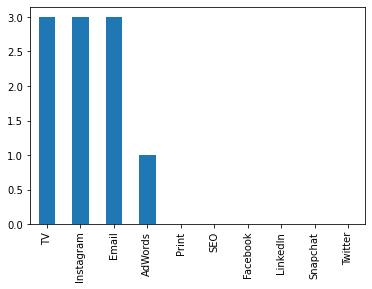

In [6]:
# Print out the result for Question 3
print('The optimal revenue we can gain is {:.3f} million'.format(AdvMod.objVal))

budget = list(Adv_x.x)
budget_dict = {}
for chn, num in zip(channel, budget):
    budget_dict[chn] = num

print("\n------Allocation--------")
print(pd.Series(budget_dict).sort_values(ascending=False))
pd.Series(budget_dict).sort_values(ascending=False).plot(kind = 'bar')

# Q4

In [7]:
# Question 4 - new ROI
obj2 = np.array(ROI.iloc[1][1:])

AdvMod1 = gp.Model()
Adv_x1 = AdvMod1.addMVar(len(obj2)) 
AdvModCon1 = AdvMod1.addMConstrs(A, Adv_x1, sense, b)
AdvMod1.setMObjective(None,obj2,0,sense=gp.GRB.MAXIMIZE) 
AdvMod1.Params.OutputFlag = 0
AdvMod1.optimize()

The optimal revenue we can gain is 0.456 million

------Allocation--------
Print        3.0
Facebook     3.0
LinkedIn     3.0
AdWords      1.0
TV           0.0
SEO          0.0
Instagram    0.0
Snapchat     0.0
Twitter      0.0
Email        0.0
dtype: float64


<AxesSubplot:>

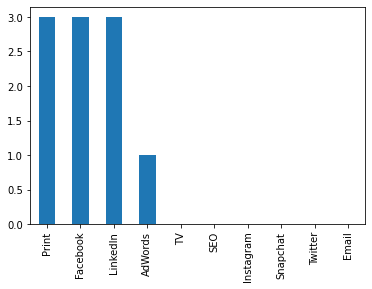

In [8]:
# Print out the result for Question 4
print('The optimal revenue we can gain is {:.3f} million'.format(AdvMod1.objVal))

budget = list(Adv_x1.x)
budget_dict = {}
for chn, num in zip(channel, budget):
    budget_dict[chn] = num

print("\n------Allocation--------")
print(pd.Series(budget_dict).sort_values(ascending=False))
pd.Series(budget_dict).sort_values(ascending=False).plot(kind = 'bar')

# Q5

### 1st ROI data & 2nd allocation

In [9]:
# Question 5
# 1st ROI data & 2nd allocation
AdvMod.objVal - obj @ Adv_x1.x

0.20400000000000007

### 2nd ROI data & 1st allocation

In [10]:
# 2nd ROI data & 1st allocation
AdvMod.objVal - obj2 @ Adv_x.x

0.19200000000000006

### Remove the 3rd constraint and rerun the model

In [11]:
# Remove the 3rd constraint and rerun the model
# New left hand side
A1 = np.zeros((3, len(obj)))
A1[0, :] = 1 # Total budget of 10M
A1[1, [channel_idx['Print'], channel_idx['TV']]] = 1 # Condition for print & TV
A1[1, [channel_idx['Facebook'], channel_idx['Email']]] = -1
A1[2, [channel_idx['SEO'], channel_idx['AdWords']]] = 2 # Condition for SEO & AdWord
A1[2, [channel_idx['Facebook'], channel_idx['LinkedIn'], channel_idx['Instagram'], channel_idx['Snapchat'], channel_idx['Twitter']]] = -1

# New right hand side
b1 = np.zeros(3)
b1[0] = 10

sense1 = np.array(['<']*3)

# Rerun the model with 1st ROI
AdvMod2 = gp.Model()
Adv_x2 = AdvMod2.addMVar(len(obj)) 
AdvModCon2 = AdvMod2.addMConstrs(A1, Adv_x2, sense1, b1)
AdvMod2.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) 
AdvMod2.Params.OutputFlag = 0
AdvMod2.optimize()

# Rerun the model with 2nd ROI
AdvMod3 = gp.Model()
Adv_x3 = AdvMod3.addMVar(len(obj)) 
AdvModCon3 = AdvMod3.addMConstrs(A1, Adv_x3, sense1, b1)
AdvMod3.setMObjective(None,obj2,0,sense=gp.GRB.MAXIMIZE) 
AdvMod3.Params.OutputFlag = 0
AdvMod3.optimize()

#### First ROI Results 

The optimal revenue we can gain is 0.46 million

------Allocation--------
TV           5.0
Email        5.0
Print        0.0
SEO          0.0
AdWords      0.0
Facebook     0.0
LinkedIn     0.0
Instagram    0.0
Snapchat     0.0
Twitter      0.0
dtype: float64


<AxesSubplot:>

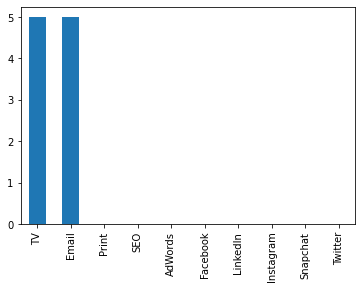

In [12]:
# Print out the result for Question 5 without the 3rd constraint
print('The optimal revenue we can gain is {:.2f} million'.format(AdvMod2.objVal))

budget = list(Adv_x2.x)
budget_dict = {}
for chn, num in zip(channel, budget):
    budget_dict[chn] = num

print("\n------Allocation--------")
print(pd.Series(budget_dict).sort_values(ascending=False))
pd.Series(budget_dict).sort_values(ascending=False).plot(kind = 'bar')

#### Second ROI results

The optimal revenue we can gain is 0.465 million

------Allocation--------
Print        5.0
Facebook     5.0
TV           0.0
SEO          0.0
AdWords      0.0
LinkedIn     0.0
Instagram    0.0
Snapchat     0.0
Twitter      0.0
Email        0.0
dtype: float64


<AxesSubplot:>

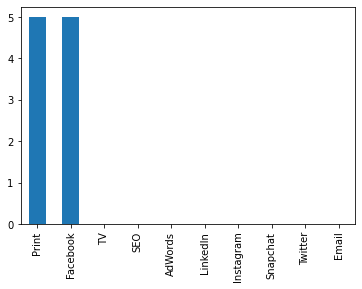

In [13]:
# Print out the result for Question 5 without the 3rd constraint
print('The optimal revenue we can gain is {:.3f} million'.format(AdvMod3.objVal))

budget = list(Adv_x3.x)
budget_dict = {}
for chn, num in zip(channel, budget):
    budget_dict[chn] = num

print("\n------Allocation--------")
print(pd.Series(budget_dict).sort_values(ascending=False))
pd.Series(budget_dict).sort_values(ascending=False).plot(kind = 'bar')

# Q6

In [14]:
# Question 6
# Sensitivity Analysis

low = pd.Series(Adv_x.SAObjLow).replace(float('-inf'), 0)*100
high = pd.Series(Adv_x.SAObjUp).replace(float('inf'), 0.1)*100

sa_df = pd.DataFrame({'Medium' : channel, 'Low' : low, 'High' : high, 'roi' : np.array(ROI.iloc[0][1:])*100})
sa_df['roi_low'] = sa_df['roi'] - sa_df['Low'] 
sa_df['high_roi'] = sa_df['High'] - sa_df['roi']

sa_df

,Medium,Low,High,roi,roi_low,high_roi
0,Print,0.0,4.9,3.1,3.1,1.8
1,TV,3.9,6.2,4.9,1.0,1.3
2,SEO,0.0,3.9,2.4,2.4,1.5
3,AdWords,3.3,4.6,3.9,0.6,0.7
4,Facebook,0.0,2.9,1.6,1.6,1.3
5,LinkedIn,0.0,3.9,2.4,2.4,1.5
6,Instagram,3.9,10.0,4.6,0.7,5.4
7,Snapchat,0.0,3.9,2.6,2.6,1.3
8,Twitter,0.0,3.9,3.3,3.3,0.6
9,Email,2.9,10.0,4.4,1.5,5.6


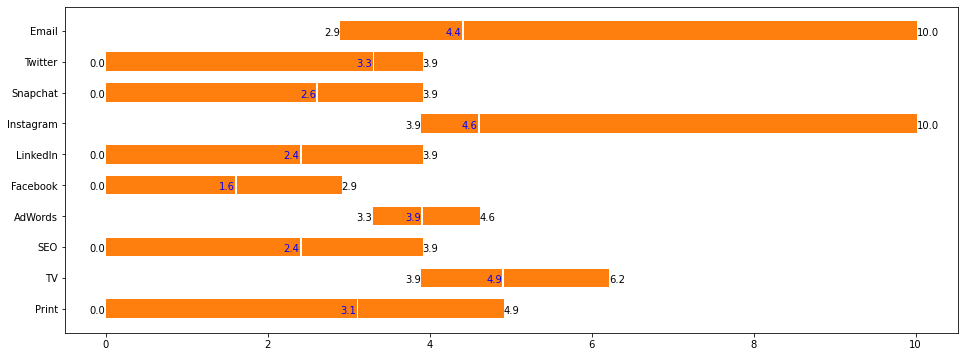

In [15]:
fig, ax = plt.subplots(figsize=(16,6))
for i in range(sa_df.shape[0]):
    ax.broken_barh([
        (sa_df.iloc[i]['Low'], sa_df.iloc[i]['roi_low']),
        (sa_df.iloc[i]['roi']+0.02, sa_df.iloc[i]['high_roi'])], 
        (i+0.2, 0.6), 
        facecolors='tab:orange')
    ax.annotate(str(round(sa_df.iloc[i]['roi'],3)), (sa_df.iloc[i]['roi']-0.2, i+0.35), color='blue')
    ax.annotate(str(round(sa_df.iloc[i]['Low'],3)), (sa_df.iloc[i]['Low']-0.2, i+0.35), color = 'black')
    ax.annotate(str(round(sa_df.iloc[i]['High'],3)), (sa_df.iloc[i]['High']+0.015, i+0.35), color = 'black')
ax.yaxis.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
ax.yaxis.set_ticklabels(channel)
plt.show()

In [16]:
# Question 7 - with 1st ROI
# Inital condition
obj3 = np.array(ROI.iloc[0][1:])
budget = 10

# Left hand side
A3 = np.zeros((len(obj)+3, len(obj)))
A3[0:len(obj), 0:len(obj)] = np.identity(len(obj)) # Condition for each less than 3M
A3[len(obj), :] = 1 # Total budget of 10M
A3[len(obj)+1, [channel_idx['Print'], channel_idx['TV']]] = 1 # Condition for print & TV
A3[len(obj)+1, [channel_idx['Facebook'], channel_idx['Email']]] = -1
A3[len(obj)+2, [channel_idx['SEO'], channel_idx['AdWords']]] = 2 # Condition for SEO & AdWord
A3[len(obj)+2, [channel_idx['Facebook'], channel_idx['LinkedIn'], channel_idx['Instagram'], channel_idx['Snapchat'], channel_idx['Twitter']]] = -1

monthly_allocation = {}
for i in roi_mat.index:
    
    # Right hand side
    b3 = np.zeros(len(obj)+3)
    b3[:len(obj)] = 3
    b3[len(obj)] = budget

    sense = np.array(['<']*(len(obj)+3))

    # Use gurobi to optimize the solution
    AdvMod4 = gp.Model()
    Adv_x4 = AdvMod4.addMVar(len(obj)) 
    AdvModCon4 = AdvMod4.addMConstrs(A3, Adv_x4, sense, b3)
    AdvMod4.setMObjective(None,obj3,0,sense=gp.GRB.MAXIMIZE) 
    AdvMod4.Params.OutputFlag = 0
    AdvMod4.optimize()
    
    profit = Adv_x4.x @ np.array(roi_mat.loc[i][0:]) / 100
    budget += profit*0.5
    
    monthly_allocation[i] = Adv_x4.x

first_ROI_monthly = pd.DataFrame(monthly_allocation).T
first_ROI_monthly.set_axis(channel, axis=1, inplace=True)
first_ROI_monthly['Total'] = first_ROI_monthly.sum(axis = 1)
first_ROI_monthly

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,Total
January,0.0,3.0,0.0,1.000000,0.0,0.0,3.0,0.0,0.000000,3.0,10.000000
February,0.0,3.0,0.0,1.180000,0.0,0.0,3.0,0.0,0.000000,3.0,10.180000
March,0.0,3.0,0.0,1.353920,0.0,0.0,3.0,0.0,0.000000,3.0,10.353920
April,0.0,3.0,0.0,1.505381,0.0,0.0,3.0,0.0,0.010763,3.0,10.516144
May,0.0,3.0,0.0,1.564986,0.0,0.0,3.0,0.0,0.129971,3.0,10.694957
June,0.0,3.0,0.0,1.629829,0.0,0.0,3.0,0.0,0.259657,3.0,10.889486
July,0.0,3.0,0.0,1.699709,0.0,0.0,3.0,0.0,0.399418,3.0,11.099126
August,0.0,3.0,0.0,1.773336,0.0,0.0,3.0,0.0,0.546672,3.0,11.320008
September,0.0,3.0,0.0,1.845758,0.0,0.0,3.0,0.0,0.691517,3.0,11.537275
October,0.0,3.0,0.0,1.908289,0.0,0.0,3.0,0.0,0.816578,3.0,11.724866


In [17]:
# Question 7 - with 2nd ROI
# Inital condition
obj4 = np.array(ROI.iloc[1][1:])
budget = 10

# Left hand side
A3 = np.zeros((len(obj)+3, len(obj)))
A3[0:len(obj), 0:len(obj)] = np.identity(len(obj)) # Condition for each less than 3M
A3[len(obj), :] = 1 # Total budget of 10M
A3[len(obj)+1, [channel_idx['Print'], channel_idx['TV']]] = 1 # Condition for print & TV
A3[len(obj)+1, [channel_idx['Facebook'], channel_idx['Email']]] = -1
A3[len(obj)+2, [channel_idx['SEO'], channel_idx['AdWords']]] = 2 # Condition for SEO & AdWord
A3[len(obj)+2, [channel_idx['Facebook'], channel_idx['LinkedIn'], channel_idx['Instagram'], channel_idx['Snapchat'], channel_idx['Twitter']]] = -1

second_monthly_allocation = {}
for i in roi_mat.index:
    
    # Right hand side
    b3 = np.zeros(len(obj)+3)
    b3[:len(obj)] = 3
    b3[len(obj)] = budget

    sense = np.array(['<']*(len(obj)+3))

    # Use gurobi to optimize the solution
    AdvMod5 = gp.Model()
    Adv_x5 = AdvMod5.addMVar(len(obj)) 
    AdvModCon5 = AdvMod5.addMConstrs(A3, Adv_x5, sense, b3)
    AdvMod5.setMObjective(None,obj4,0,sense=gp.GRB.MAXIMIZE) 
    AdvMod5.Params.OutputFlag = 0
    AdvMod5.optimize()
    
    profit = Adv_x5.x @ np.array(roi_mat.loc[i][0:]) / 100
    budget += profit*0.5
    
    second_monthly_allocation[i] = Adv_x5.x

second_ROI_monthly = pd.DataFrame(second_monthly_allocation).T
second_ROI_monthly.set_axis(channel, axis=1, inplace=True)
second_ROI_monthly['Total'] = second_ROI_monthly.sum(axis = 1)
second_ROI_monthly  

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,Total
January,3.0,0.0,0.0,1.000000,3.0,3.0,0.0,0.0,0.000000,0.0,10.000000
February,3.0,0.0,0.0,1.177000,3.0,3.0,0.0,0.0,0.000000,0.0,10.177000
March,3.0,0.0,0.0,1.371863,3.0,3.0,0.0,0.0,0.000000,0.0,10.371863
April,3.0,0.0,0.0,1.547928,3.0,3.0,0.0,0.0,0.000000,0.0,10.547928
May,3.0,0.0,0.0,1.731983,3.0,3.0,0.0,0.0,0.000000,0.0,10.731983
June,3.0,0.0,0.0,1.894927,3.0,3.0,0.0,0.0,0.000000,0.0,10.894927
July,3.0,0.0,0.0,2.083140,3.0,3.0,0.0,0.0,0.000000,0.0,11.083140
August,3.0,0.0,0.0,2.301469,3.0,3.0,0.0,0.0,0.000000,0.0,11.301469
September,3.0,0.0,0.0,2.498300,3.0,3.0,0.0,0.0,0.000000,0.0,11.498300
October,3.0,0.0,0.0,2.711265,3.0,3.0,0.0,0.0,0.000000,0.0,11.711265
